In [51]:
# librairies
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, precision_score, precision_recall_curve, classification_report, confusion_matrix, accuracy_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import scipy.io as sp

In [52]:
#traitement fichier.mat
dataset=sp.loadmat('breastw.mat')
X = dataset['X']
y = dataset['y']
#fin traitement mat

In [53]:
# Modèles KNN et Statistique + entrainement dataset

skf = StratifiedKFold(n_splits=10,shuffle=True) # équilibrage dataset

for train_index, test_index in skf.split(X,y):
    
    X_train, X_test = X[train_index,:], X[test_index,:]
    y_train, y_test = y[train_index], y[test_index]

    #Méthode Statistique Gaussienne
    model_gmm = GaussianMixture(n_components=2, covariance_type ='full', random_state = 0, max_iter=100)
    model_gmm.fit(X_train,y_train)
    y_pred_gmm = model_gmm.predict(X_test)
    y_scores_gmm = model_gmm.predict_proba(X_test)
    if precision_score(y_test,y_pred_gmm)< 0.15:
    
        y_pred_gmm = np.array([0 if label == 1 else 1 for label in y_pred_gmm])
        y_scores_gmm = 1-model_gmm.predict_proba(X_test)
        y_scores_gmm = y_scores_gmm[:, 1]
    else :
        y_scores_gmm = model_gmm.predict_proba(X_test)
        y_scores_gmm = y_scores_gmm[:, 1]
    #Fin méthode stat

    #Méthode KNN
    k=5
    #algo knn
    model_KNN = KNeighborsClassifier(n_neighbors=k)
    model_KNN.fit(X_train,y_train)
    y_pred_KNN= model_KNN.predict(X_test)
    model_PCA = PCA(n_components=2)
    data_reduced = model_PCA.fit_transform(X_test)
    #fin algo knn
    y_scores_KNN = model_KNN.predict_proba(X_test)
    y_scores_KNN = y_scores_KNN[:, 1]
    #Fin méthode KNN

C:\Users\achan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\achan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\achan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\achan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sam

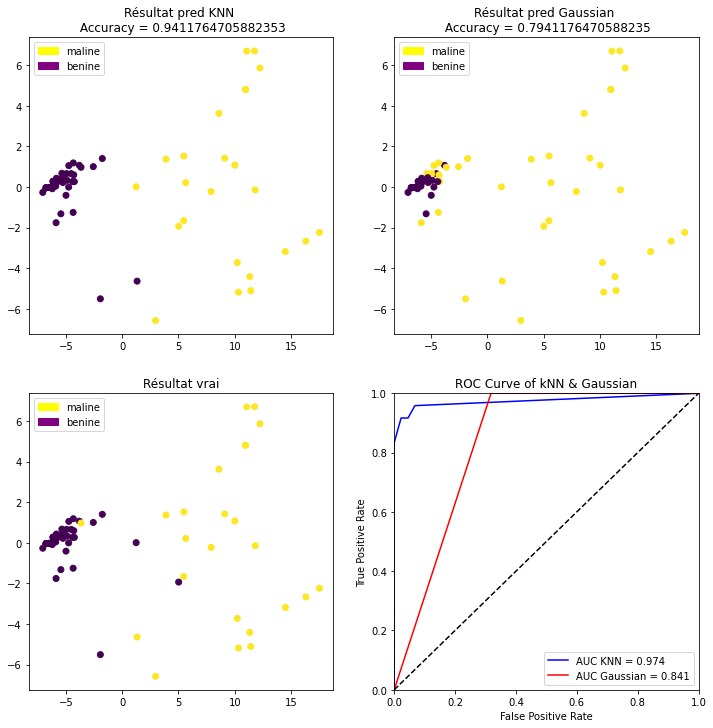

In [54]:
# Plot graphique

plt.figure(figsize=(12,12))

#Calculs Accuracy KNN
Accuracy_KNN = accuracy_score(y_test, y_pred_KNN)
Accuracy_gmm = accuracy_score(y_test, y_pred_gmm)

plt.subplot(2, 2, 1)
plt.scatter(data_reduced[:,0],data_reduced[:,1],c=y_pred_KNN) #Nuage de points prédictif KNN
plt.title("Résultat pred KNN \n Accuracy = {}".format(Accuracy_KNN))
maline = mpatches.Patch(color='yellow', label='maline')
benine = mpatches.Patch(color='purple', label='benine')
plt.legend(handles=[maline,benine])

plt.subplot(2, 2, 2)
plt.scatter(data_reduced[:,0],data_reduced[:,1],c=y_pred_gmm) #Nuage de points prédictif KNN
plt.title("Résultat pred Gaussian \n Accuracy = {}".format(Accuracy_gmm))
maline = mpatches.Patch(color='yellow', label='maline')
benine = mpatches.Patch(color='purple', label='benine')
plt.legend(handles=[maline,benine])

plt.subplot(2, 2, 3)
plt.scatter(data_reduced[:,0],data_reduced[:,1],c=y_test) #Nuage de points vrai
plt.title("Résultat vrai")
maline = mpatches.Patch(color='yellow', label='maline')
benine = mpatches.Patch(color='purple', label='benine')
plt.legend(handles=[maline,benine])

#  ROC curve
fpr_KNN, tpr_KNN, threshold_KNN = roc_curve(y_test, y_scores_KNN) #ROC pour KNN
roc_auc_KNN = auc(fpr_KNN, tpr_KNN)
#print("AUC: ", roc_auc_KNN)
fpr_gmm, tpr_gmm, thresholds_gmm = roc_curve(y_test,y_pred_gmm) #ROC pour Gaussien
roc_auc_gmm = auc(fpr_gmm, tpr_gmm)

plt.subplot(2, 2, 4)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_KNN, tpr_KNN, 'b', label = 'AUC KNN = %0.3f' % roc_auc_KNN)
plt.plot(fpr_gmm, tpr_gmm, 'r', label = 'AUC Gaussian = %0.3f' % roc_auc_gmm)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN & Gaussian')
plt.show()
#fin graphique

In [55]:
# Matrice de  confusion, F1-score etc...

# Méthode KNN
result = confusion_matrix(y_test, y_pred_KNN)
print("Matrice de confusion KNN :")
print(result)
result1 = classification_report(y_test, y_pred_KNN)
print("Classification Report KNN :",)
print (result1)
print("Accuracy KNN :", Accuracy_KNN, "\n")

# Méthode Statistique Gaussien
result = confusion_matrix(y_test, y_pred_gmm)
print("Matrice de confusion Gaussien :")
print(result)
result1 = classification_report(y_test, y_pred_gmm)
print("Classification Report Gaussian :",)
print (result1)
print("Accuracy Gaussian :", Accuracy_gmm)

Matrice de confusion KNN :
[[42  2]
 [ 2 22]]
Classification Report KNN :
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        44
           1       0.92      0.92      0.92        24

    accuracy                           0.94        68
   macro avg       0.94      0.94      0.94        68
weighted avg       0.94      0.94      0.94        68

Accuracy KNN : 0.9411764705882353 

Matrice de confusion Gaussien :
[[30 14]
 [ 0 24]]
Classification Report Gaussian :
              precision    recall  f1-score   support

           0       1.00      0.68      0.81        44
           1       0.63      1.00      0.77        24

    accuracy                           0.79        68
   macro avg       0.82      0.84      0.79        68
weighted avg       0.87      0.79      0.80        68

Accuracy Gaussian : 0.7941176470588235
